In [1]:
import os
import time
from tkinter import filedialog, Tk

import matplotlib.pyplot as plt
import numpy as np
from tifffile import tifffile

root = Tk()
root.withdraw()
root.geometry("800x600")
rPadChars = 50 * " "
root.ref_filename = filedialog.askopenfilename(
    initialdir="/DATA2/Data_CoCoS_HD/COCOS_ISM/",
    title="Select a red reference file (tif file) " + rPadChars,
    filetypes=(("tif files", "*.tif"), ("tiff files", "*.tiff"), ("all files", "*.*")),
)
images_path = os.path.dirname(root.ref_filename)
root.image_filename = filedialog.askopenfilename(
    initialdir=images_path,
    title="Select Spectral stack to analyse (tif file)",
    filetypes=(("tif files", "*.tif"), ("tiff files", "*.tiff"), ("all files", "*.*")),
)
ref_red_name_im = os.path.split(root.ref_filename)[-1]
im_rgb_name = os.path.split(root.image_filename)[-1]
root.destroy()

C:\CoCos\CoCos\.venv\lib\site-packages\cupyx\fallback_mode\__init__.py:10: FutureWarning: cupyx.fallback_mode.numpy is experimental. The interface can change in the future.
  _util.experimental('cupyx.fallback_mode.numpy')


In [2]:
# Define paths
ref_path = r"C:\Users\User\Desktop\CoCoS_ISM\Data\All_Refs"
# images_path = r"/DATA2/Data_CoCoS_HD/COCOS_ISM/beads_2811"
# images_path = r"/DATA2/Data_CoCoS_HD/COCOS_ISM/NetaCells_031224"


# Red reference to register spots locations
# ref_red_name_im = r"Ref647_300Hz_N1000_LPN2_TL12_TR1668_TCon50_TCoff15_TD1p668_TA0_Gain5_I10R.tif"
# ref_red_name_im = r"Ref647_300Hz_N1000_LPN2_TL12_TR1668_TCon50_TCoff15_TD1p668_TA0_Gain5_I10R(1).tif"

# Image stack to analyze
# im_rgb_name = r"FOV3_NetaCells_300Hz_N1000_LPN2_TL12_TR1668_TCon400_TCoff15_TD1p668_TA0_Gain500_I10PR1B5G.tif"
# im_rgb_name = r"FocCheck4umBeads_300Hz_N1000_LPN2_TL12_TR1668_TCon200_TCoff15_TD1p668_TA0_Gain500_I10P0p1B0p05GR.tif"
# im_rgb_name = r"FOV3PSbeads_300Hz_N1000_LPN2_TL12_TR1667_TCon100_TCoff15_TD1p667_TA0_Gain20_I10PG6B8R.tif"


# PSFS_NAMES=['CF647','CF568','wtGFP','DAPI']
# PSFS_NAMES = ['FC Dark Red', 'FC Red', 'FC Green']
PSFS_NAMES = ["FC Dark Red", "FS Orange", "FS Yellow-Green"]

IMPORT_PSFS = False
SIMULATE_PSFS = False

external_ref_psfs_stack_path = r"/DATA2/Data_CoCoS_HD/COCOS_ISM/Refs_080824/FluorophoreSpectraForSimulation/Simulated_PSFs.tiff"
external_ref_psfs_mat_path = r"/DATA2/Data_CoCoS_HD/COCOS_ISM/Refs_080824/FluorophoreSpectraForSimulation/Simulated_PSFs.mat"
external_ref_psfs_names_path = r"/DATA2/Data_CoCoS_HD/COCOS_ISM/Refs_080824/FluorophoreSpectraForSimulation/FluorLabelS.mat"

# Spectral reference files
ref_red_name = (
    "Ref640_N250_LPN2_TL8_TR1389p5_TCon100_TCoff15_TD5p56_TA0_Gain500_64010.tif"
)
ref_green_name = (
    "Ref560_N250_LPN2_TL8_TR1389p5_TCon100_TCoff15_TD5p56_TA0_Gain500_56010.tif"
)
ref_blue_name = (
    "Ref488_N250_LPN2_TL8_TR1389p5_TCon100_TCoff15_TD5p56_TA0_Gain500_488I10.tif"
)

spectral_ref_stack_paths = [
    os.path.join(ref_path, ref_red_name),
    os.path.join(ref_path, ref_green_name),
    os.path.join(ref_path, ref_blue_name),
]

In [3]:
import os

print(images_path)
print(ref_red_name_im)

C:/Users/User/Desktop/CoCoS_ISM/Data/170nmPSbeads-0604
ref_170nmPS_640_N250_LPN2_TL8_TR1390_TCon100_TCoff15_TD5p56_TA0_Gain5_640I10.tif


In [4]:
from get_psfs.create_psfs import new_analyze_ref_stack
from utils import flatten

# red ref of the sample
t = time.time()

peaks, mean_sigma = new_analyze_ref_stack(
    os.path.join(images_path, ref_red_name_im), skip_factor=1
)
flattened_P = np.array(flatten(peaks))

print(f" Reference Peaks localization time {time.time() - t:.2f}s")

 Reference Peaks localization time 33.50s


In [5]:
from get_high_snr_crops import estimate_noise_variance_gpu
from get_crops import get_crops_all_pictures

# Process image
snr_thresh = 1
t = time.time()

# im_rgb_name = r"FOV3_NetaCells_300Hz_N1000_LPN2_TL12_TR1668_TCon100_TCoff15_TD1p668_TA0_Gain300_I10B.tif"

rgb_path = os.path.join(images_path, im_rgb_name)
ism_path = os.path.join(images_path, f"ism_snrT{snr_thresh:.2f}_" + im_rgb_name)

decomposed_rgb_path = os.path.join(
    images_path, f"decomposed_RGB_snrT{snr_thresh:.2f}_" + im_rgb_name
)

# get the crops

with tifffile.TiffFile(rgb_path) as tif:
    num_images = len(tif.pages)
    stack = tif.asarray()
# stack=stack[::2]
all_crops, all_crops_max, stack_mean, stack_std = get_crops_all_pictures(
    stack, peaks, median_calc=True
)
stack_std_val = np.std(stack)
# stack_med_val=np.median(stack)

print(f" Time to get all crops:  {time.time() - t:.2f}s")

# filter the prominent crops:

noise, snr = estimate_noise_variance_gpu(all_crops)

high_snr_ind = np.where(snr > snr_thresh)[0]
# crops_with_high_intensity,peaks_with_high_intensity, rounded_peaks,std_thresh, mean_thresh = get_prominent_crops(all_crops,flattened_P,threshSNR=5,plot_flag=False)
peaks_with_high_intensity = flattened_P[high_snr_ind]
crops_with_high_intensity = all_crops[high_snr_ind]
# rounded_peaks = np.round(peaks_with_high_intensity)

# Spectral_IM = compose_im_from_rgb_crops(crops_with_high_intensity, rounded_peaks)
# #rescale images to save as imagej tiff:
# calcSpectralIm = rescale_float32_to_uint16(Spectral_IM)
#
# decomposed_Spectral_path = os.path.join(images_path, f"decomposed_Spectral_snrT{snr_thresh:.2f}_" + im_rgb_name)
# tifffile.imwrite(decomposed_rgb_path, data=cp.asnumpy(calcSpectralIm).transpose((2, 0, 1)), metadata={"axes": "CYX"},
#                  imagej=True)

 Time to get all crops:  3.52s


In [ ]:
from utils import RED_X_LOCATION
from get_psfs.simulate_psfs import simulate_psfs
from get_psfs.create_psfs import import_external_ref_psfs, average_crop_all_pictures

# refrence psfs
if IMPORT_PSFS:
    spsfs, spsfs_mat, spsfs_mat_names = import_external_ref_psfs(
        external_ref_psfs_stack_path,
        external_ref_psfs_mat_path,
        external_ref_psfs_names_path,
    )
    # fl_names=flatten([name.tolist() for name in spsfs_mat_names.get('FluorLabelS')[0]])
    spsfs = flatten(spsfs_mat.get("Simulated_PSFs")[0])
    psfs = spsfs[0]
    # fl_names=spsfs[1]
    fl_names = flatten([name.tolist() for name in spsfs[1]])
    fig = plt.figure(figsize=(10, 20))
    axs = fig.subplots(nrows=psfs.shape[0], ncols=1, sharex=True, sharey=True)
    for i in range(psfs.shape[0]):
        axs[i].imshow(psfs[:, :, i])
        # axs[i].set_xticks([])
        # axs[i].set_yticks([])
        axs[i].set_ylabel(fl_names[i])
    ind_psfs = [
        ind_psfs for ind_psfs, name in enumerate(fl_names) if name in PSFS_NAMES
    ]
    psfs = psfs[:, :, ind_psfs]  # .transpose(1, 2, 0)
elif SIMULATE_PSFS:
    psfs, fl_names = simulate_psfs(
        crop_size=(9, 19), red_shift=19 - RED_X_LOCATION, sigma=mean_sigma
    )
    fig = plt.figure(figsize=(10, 20))
    axs = fig.subplots(nrows=psfs.shape[0], ncols=1, sharex=True, sharey=True)
    for i in range(psfs.shape[0]):
        axs[i].imshow(psfs[:, :, i])
        # axs[i].set_xticks([])
        # axs[i].set_yticks([])
        axs[i].set_ylabel(fl_names[i])
    ind_psfs = [
        ind_psfs for ind_psfs, name in enumerate(fl_names) if name in PSFS_NAMES
    ]
    psfs = psfs[:, :, ind_psfs]  # .transpose(1, 2, 0)
else:
    t = time.time()
    reference_peaks, sigmas = new_analyze_ref_stack(
        os.path.join(ref_path, ref_red_name)
    )
    # print(time.time() - t)
    psfs = average_crop_all_pictures(spectral_ref_stack_paths, reference_peaks)
    print(f" Reference PSFs calculation {time.time() - t:.2f}s")

In [ ]:
from crops_to_image import reconstruct_RGB_crops_OLS
from to_distribute import get_crop_basis

start_time = time.time()
num_channels = psfs.shape[-1]
basis_images = get_crop_basis(psfs)
# basis_images = get_crop_basis_no_grad(psfs)

reconstructed_sepctral_crops, reconstructed_RGB_crops = reconstruct_RGB_crops_OLS(
    crops_with_high_intensity, basis_images, grad_flag=True
)
error_map = reconstructed_sepctral_crops - crops_with_high_intensity
rounded_peaks = np.round(peaks_with_high_intensity)
print(f" Time to reconstruct {time.time() - start_time:.2f}s")

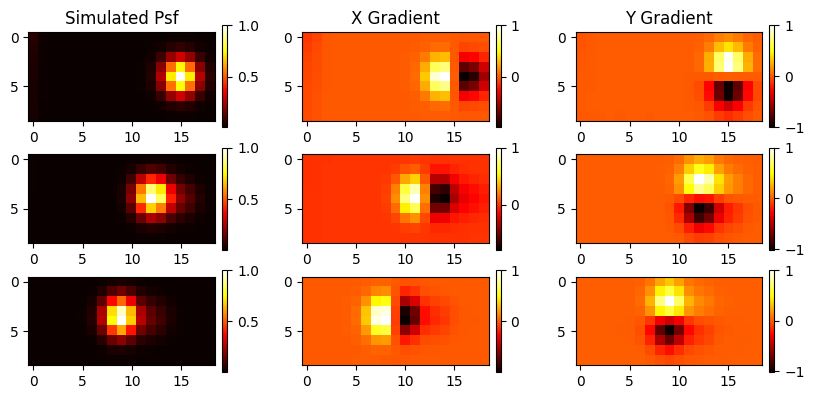

In [20]:
fig, axs = plt.subplots(nrows=psfs.shape[-1], ncols=3, figsize=(10, 4.5))
psfs_t = basis_images[:num_channels]
psf_dx = basis_images[num_channels : 2 * num_channels]
psf_dy = basis_images[2 * num_channels : 3 * num_channels]
_pad = 0.03
for i in range(basis_images.shape[0] // 3):
    p_crop = axs[i][0].imshow(psfs_t[i], cmap="hot")
    p_dx = axs[i][1].imshow(psf_dx[i], cmap="hot")
    p_dy = axs[i][2].imshow(psf_dy[i], cmap="hot")
    plt.colorbar(p_crop, ax=axs[i][0], pad=_pad)
    plt.colorbar(p_dx, ax=axs[i][1], pad=_pad)
    plt.colorbar(p_dy, ax=axs[i][2], pad=_pad)
    axs[0][0].set_title("Simulated Psf")
axs[0][1].set_title("X Gradient")
axs[0][2].set_title("Y Gradient")
plt.show()

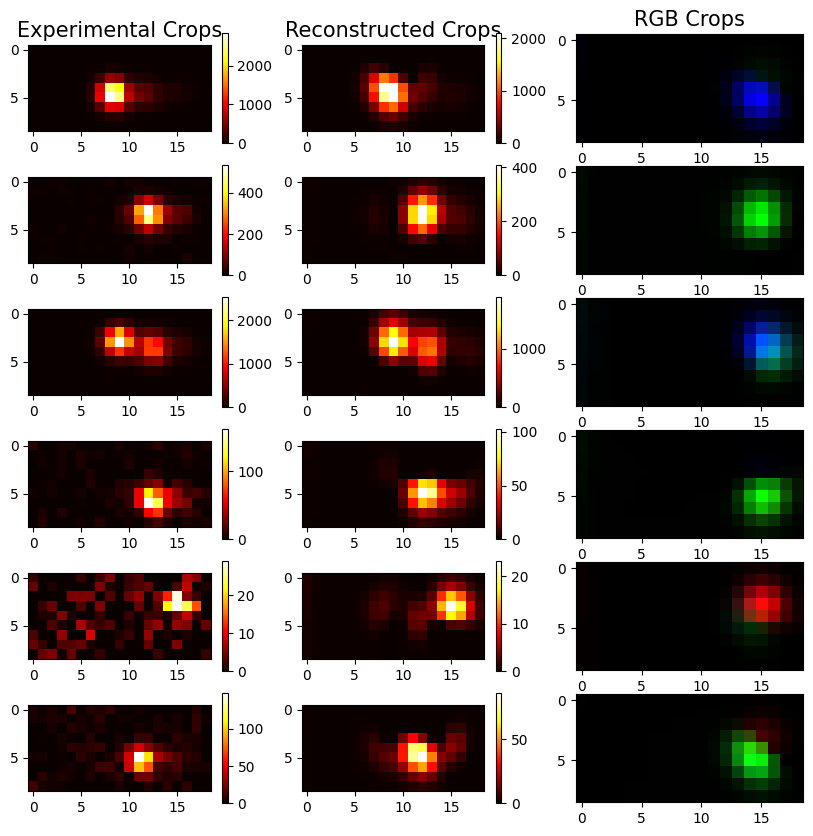

In [21]:
fig, axs = plt.subplots(nrows=6, ncols=3, figsize=(10, 10))
_pad = 0.05

for i, ax in enumerate(axs):
    p_crop = axs[i][0].imshow(crops_with_high_intensity[i], cmap="hot")
    # axs[i][0].set_title(f'{i}-SNR: {snr[high_snr_ind[i]]:.1f}')
    p_reconS = axs[i][1].imshow(reconstructed_sepctral_crops[i], cmap="hot")
    p_reconRGB = axs[i][2].imshow(
        reconstructed_RGB_crops[i] / np.max(reconstructed_RGB_crops[i])
    )
    plt.colorbar(p_crop, ax=axs[i][0], pad=_pad)
    plt.colorbar(p_reconS, ax=axs[i][1], pad=_pad)
    # plt.colorbar(p_reconRGB,ax=ax[i][2], pad=_pad)
    axs[0][0].set_title("Experimental Crops", fontsize=15)
axs[0][1].set_title("Reconstructed Crops", fontsize=15)
axs[0][2].set_title("RGB Crops", fontsize=15)
plt.show()
# fig, ax = plt.subplots(nrows=10, ncols=10, figsize=(20, 20))
# for i, ax in enumerate(ax.flat):
#     ax.imshow(reconstructed_sepctral_crops[i], cmap='hot')
#     ax.set_title(f'{i}-SNR: {snr[high_snr_ind[i]]:.1f}')
# plt.show()
# # fig,ax=plt.subplots(nrows=10,ncols=10,figsize=(20,20))
# # for i,ax in enumerate(ax.flat):
# #     ax.imshow(reconstructed_RGB_crops[i])
# #     # ax.set_title(f'{i}-SNR: {snr[high_snr_ind[i]]:.1f}')
# plt.show()

In [23]:
from crops_to_image import compose_im_from_rgb_crops
import cupy as cp
from utils import rescale_float32_to_uint16

RGB_IM = compose_im_from_rgb_crops(reconstructed_RGB_crops, rounded_peaks)
# rescale images to save as imagej tiff:
calcRGBim = rescale_float32_to_uint16(RGB_IM)
decomposed_rgb_path = os.path.join(
    images_path, f"decomposed_RGB_snrT{snr_thresh:.2f}_" + im_rgb_name
)

# decomposed_rgb_path = os.path.join(images_path, f"NoGrad_decomposed_RGB_snrT{snr_thresh:.2f}_" + im_rgb_name)
tifffile.imwrite(
    decomposed_rgb_path,
    data=cp.asnumpy(calcRGBim).transpose((2, 0, 1)),
    metadata={"axes": "CYX"},
    imagej=True,
)
#

In [24]:
from ism import run_ism

# RUN  ISM
M = 8
ism_image = run_ism(
    all_convolved_crops=reconstructed_RGB_crops,
    M=M,
    peaks=peaks_with_high_intensity,
    scatter_add_batch_size=10000,
)

calcISMim = rescale_float32_to_uint16(ism_image)
ism_path = os.path.join(images_path, f"ism_snrT{snr_thresh:.2f}_M{M}_" + im_rgb_name)

# ism_path = os.path.join(images_path, f"NoGrad_ism_snrT{snr_thresh:.2f}_M{M}_" + im_rgb_name)

tifffile.imwrite(
    ism_path, data=calcISMim.transpose((2, 0, 1)), metadata={"axes": "CYX"}, imagej=True
)

NameError: name 'RED_XLOC' is not defined

In [175]:
# # deconv_ism=fourier_deconvolution_gpu(ism_image, psfs[:,RED_XLOC-9//2:RED_XLOC+9//2,0], regularization=1e-6).get()
# lamda_reg = 0.1
# num_iter_deconv = 40
# deconv_ism = sparse_deconvolution_ista_centered(ism_image, psfs[:, RED_XLOC - 10 // 2:RED_XLOC + 9 // 2 + 1, 0],
#                                                 lambda_reg=lamda_reg, num_iterations=num_iter_deconv)
# calcDeconvISMim = rescale_float32_to_uint16(deconv_ism)
# ism_deconv_path = os.path.join(images_path,
#                                f"ism_deconv_snrT{snr_thresh:.2f}_reg{lamda_reg:.2f}_iter{num_iter_deconv:.2f}" + im_rgb_name)
#
# # ism_deconv_path = os.path.join(images_path,
# #                                f"NoGrad_ism_deconv_snrT{snr_thresh:.2f}_reg{lamda_reg:.2f}_iter{num_iter_deconv:.2f}" + im_rgb_name)
# tifffile.imwrite(ism_deconv_path, data=calcDeconvISMim.transpose((2, 0, 1)), metadata={"axes": "CYX"}, imagej=True)
#



In [176]:
# from scipy.ndimage import zoom
# import plotly.express as px
# from plotly.offline import plot
# from plotly.subplots import make_subplots
# def myimrescale(Im, factors):
#     # Calculate the minimum and maximum values
#     im_min = np.median(Im, axis=(0, 1)) * factors[0]
#     im_max = np.max(Im, axis=(0, 1)) * factors[1]
#
#     # Rescale the image
#     Im_rescaled = (Im - im_min) / (im_max - im_min) * 255
#     Im_rescaled = np.clip(Im_rescaled, 0, 255)
#     return Im_rescaled.astype(np.uint8)
#
# contrast_factors = [0.9, 0.2]
# rescaled_image = zoom(myimrescale(RGB_IM, contrast_factors),(2.,2.,1.),mode='nearest')
# rescaled_ism = myimrescale(ism_image, contrast_factors)
# rescaled_ism_deconv=myimrescale(deconv_ism, contrast_factors)
# # fig=plt.figure(figsize=(20,20))
#
#
#
#
# figures = [
#     px.imshow(rescaled_image,height=800),
#     px.imshow(rescaled_ism,height=800),
#     px.imshow(rescaled_ism_deconv,height=800)
#     ]
#
# fig = make_subplots(rows=1, cols=len(figures),shared_xaxes=True,horizontal_spacing=0.05, vertical_spacing=0.05)
#
# for i, figure in enumerate(figures):
#     for trace in range(len(figure["data"])):
#         fig.add_trace(figure["data"][trace], row=1, col=i+1)
#
# fig.show()

In [177]:
# rescaled_ism_deconv=myimrescale(deconv_ism, contrast_factors)
#
# px.imshow(rescaled_ism_deconv,height=800)

In [178]:
# fig,ax=plt.subplots(nrows=10,ncols=10,figsize=(20,20))
# for i,ax in enumerate(ax.flat):
#     ax.imshow(crops_with_high_intensity[i],cmap='hot')
#     ax.set_title(f'{i}-SNR: {snr[high_snr_ind[i]]:.1f}')
# plt.show()

In [179]:
# heatmap, xedges, yedges = np.histogram2d(flattened_P[:,0]*2, flattened_P[:,1]*2, bins=(sz_Im,sz_Im))
# plt.figure(figsize=(10,10))
# plt.imshow(heatmap, cmap='hot', vmin=0, vmax=0.04)
# plt.ylabel(f'Multiplication fcator:{mul[i]}')
# plt.colorbar()

In [180]:
# heatmaps=[]
# extents=[]
# maxH=[]
# locs=[]
# mul=[i for i in range(8,15)]
# for i in range(len(mul)):
#     sz_Im=512*mul[i]
#     heatmap, xedges, yedges = np.histogram2d(flattened_P[:,0]*2, flattened_P[:,1]*2, bins=(sz_Im,sz_Im))
#     extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
#     heatmaps.append(heatmap)
#     extents.append(extent)
#     maxH.append(np.max(heatmap))
#     locs.append(np.where(heatmap == np.max(heatmap)))
#
# # _maxI=np.max(heatmap)
# # plt.figure(figsize=(20,20))
# # plt.imshow(heatmap.T, extent=extent, origin='lower',cmap='hot',vmax=.5)
# # plt.colorbar()
# # plt.show()
#
#
#
# # plt.scatter(peaks_with_high_intensity)
# fig,ax=plt.subplots(nrows=len(heatmaps),ncols=1,figsize=(120,120))
# for i,ax in enumerate(ax.flat):
#     p=ax.imshow(heatmaps[i].T/np.mean(heatmaps[i].T),extent=extents[i],cmap='hot')
#     ax.set_ylabel(f'Multiplication fcator:{mul[i]}')
#     plt.colorbar(p,ax=ax,pad=0.05)
plt.show()

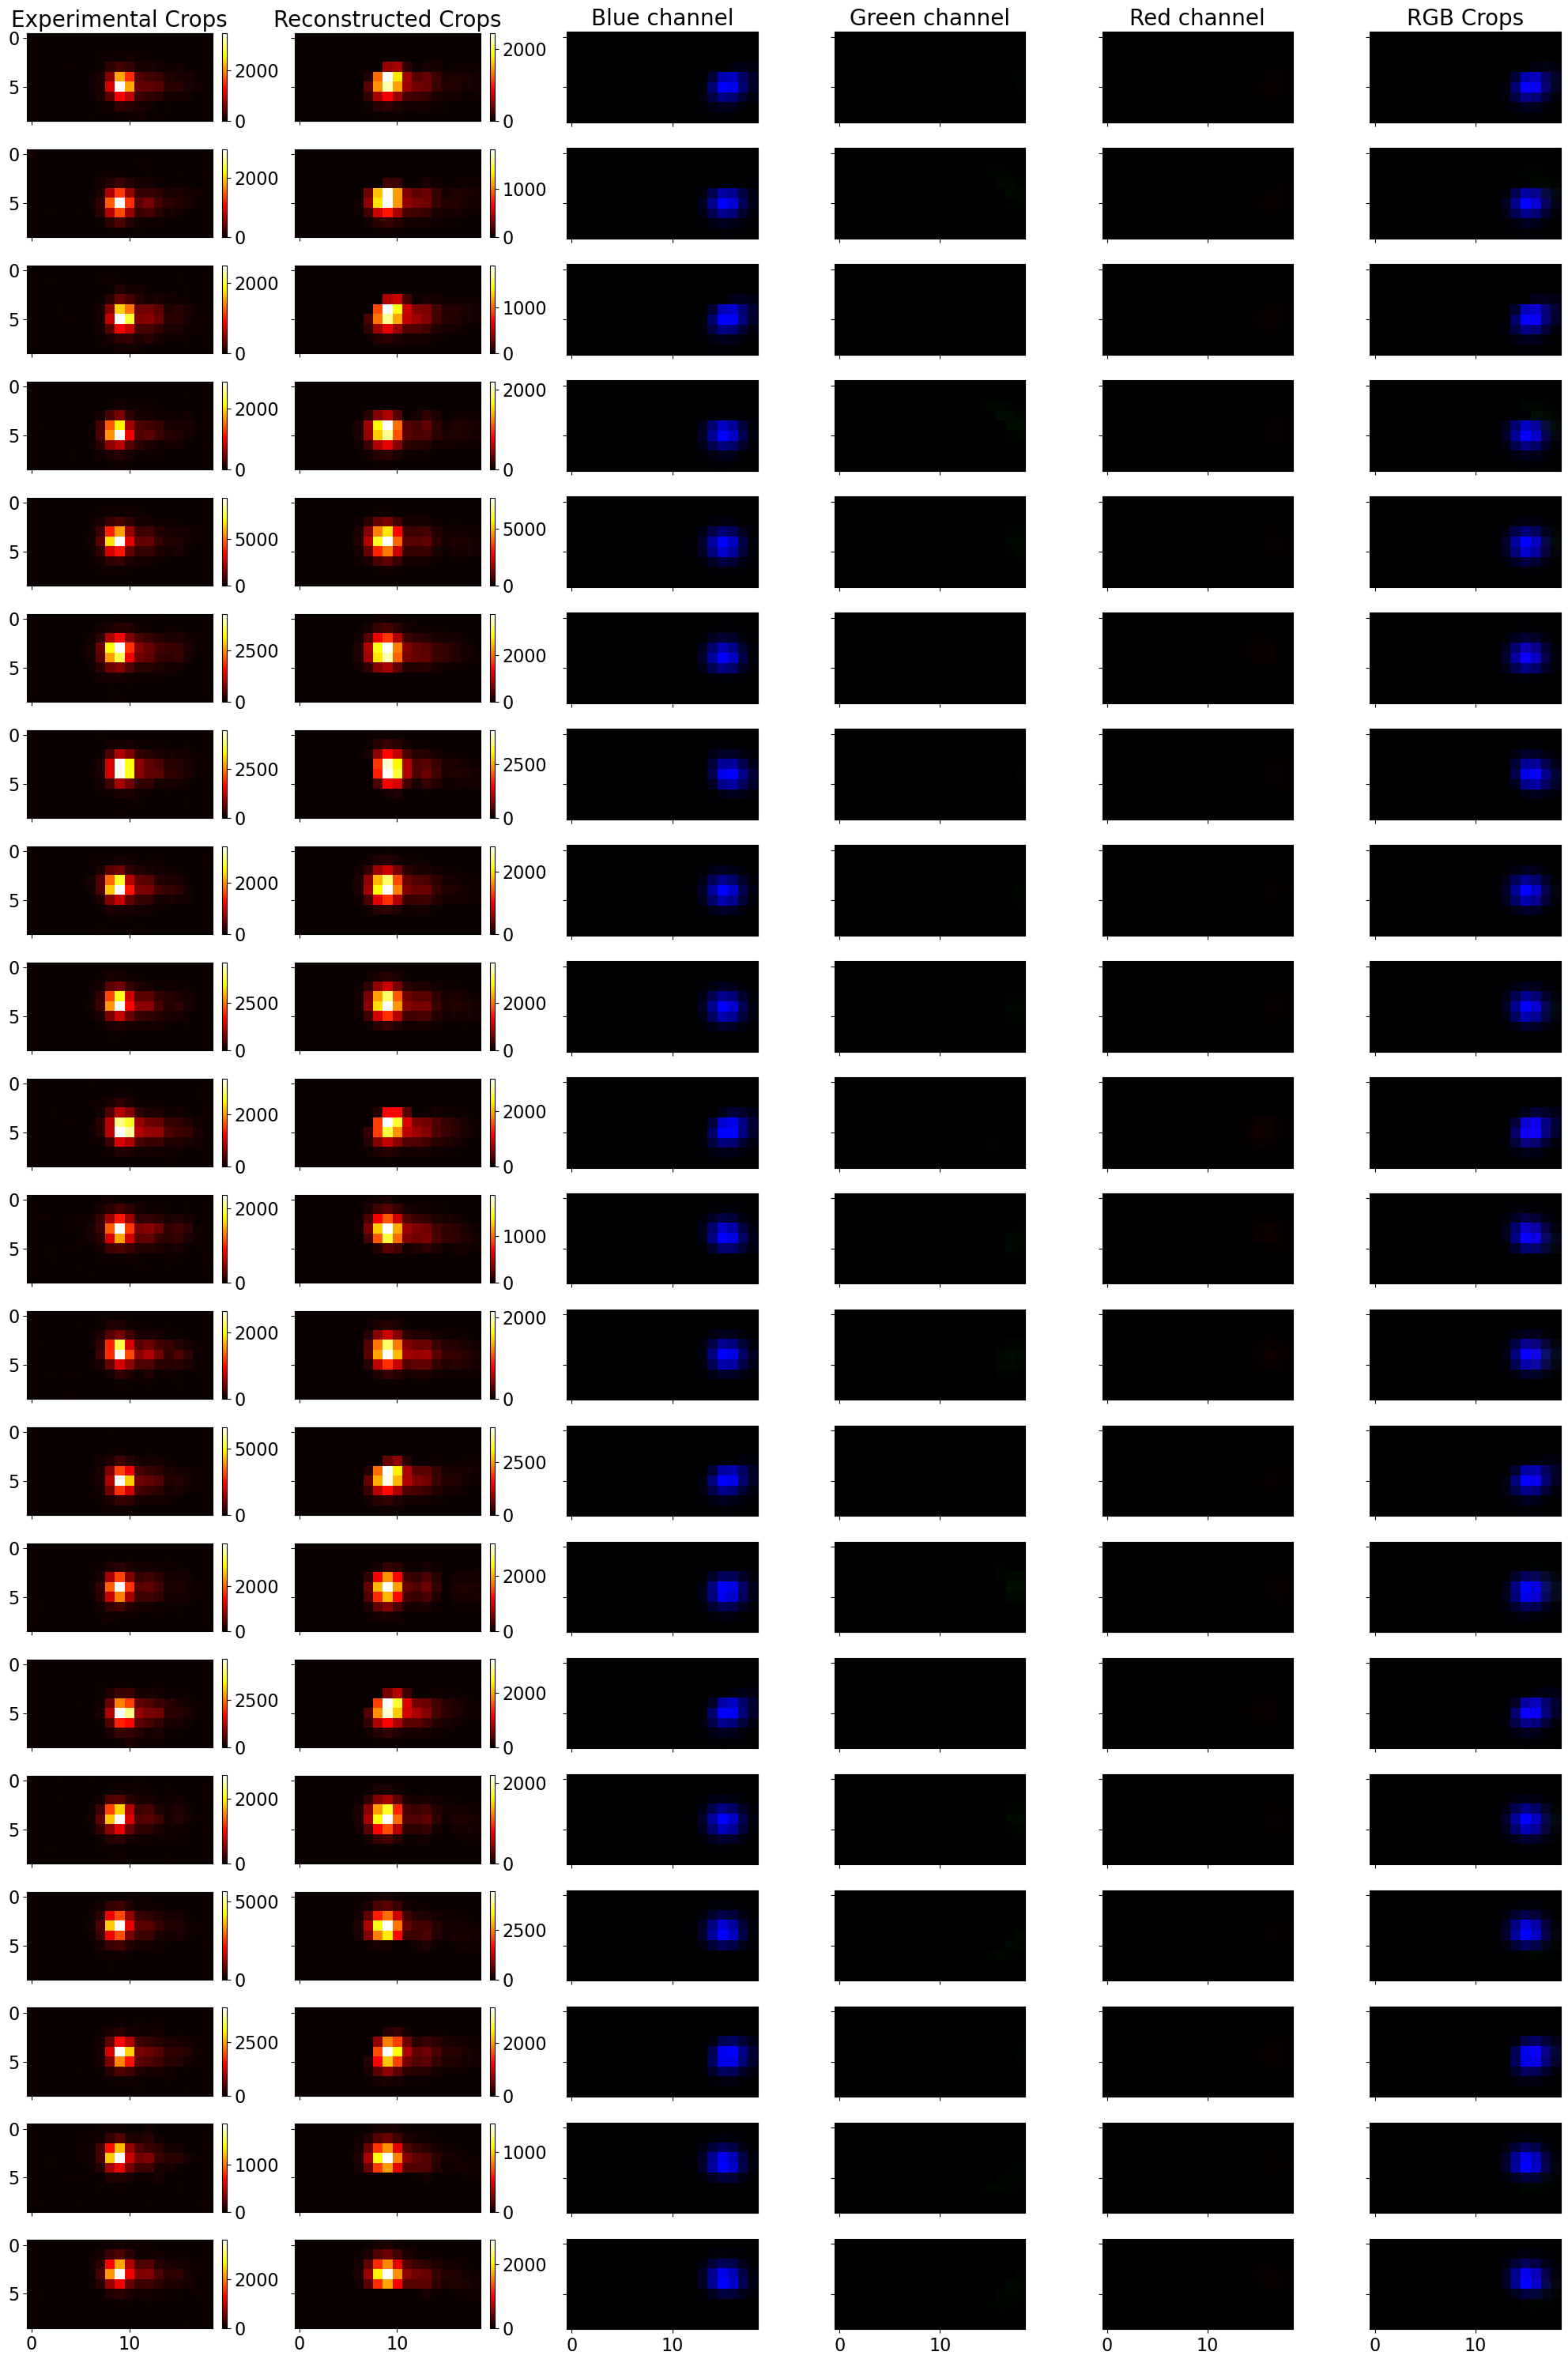

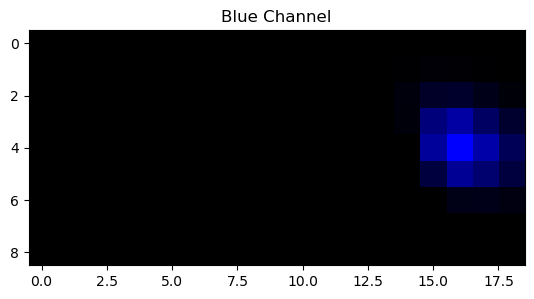

In [181]:
fig, axs = plt.subplots(nrows=20, ncols=6, figsize=(20, 30), sharex=True, sharey=True)
_pad = 0.05
zero_ch = np.zeros_like(reconstructed_RGB_crops[0])
filtered_blue_crops = np.where(
    np.max(reconstructed_RGB_crops[:1000, ..., 2], axis=(1, 2))
    > np.squeeze(
        np.sum(np.max(reconstructed_RGB_crops[:1000, ..., 0:1], axis=3), axis=(1, 2))
    )
    + 1000
)[0]
for i, ax in enumerate(axs):
    # j=i+120
    j = filtered_blue_crops[i]
    p_crop = axs[i][0].imshow(crops_with_high_intensity[j], cmap="hot")
    axs[i][0].tick_params(labelsize=16)
    # axs[i][0].set_title(f'{i}-SNR: {snr[high_snr_ind[i]]:.1f}')
    p_reconS = axs[i][1].imshow(reconstructed_sepctral_crops[j], cmap="hot")

    crop = np.copy(zero_ch)
    crop[..., 0] = reconstructed_RGB_crops[j, ..., 0] / np.max(
        reconstructed_RGB_crops[j, ...]
    )
    p_reconR = axs[i][4].imshow(crop)

    crop = np.copy(zero_ch)
    crop[..., 1] = reconstructed_RGB_crops[j, ..., 1] / np.max(
        reconstructed_RGB_crops[j, ...]
    )
    p_reconG = axs[i][3].imshow(crop)

    crop = np.copy(zero_ch)
    crop[..., 2] = reconstructed_RGB_crops[j, ..., 2] / np.max(
        reconstructed_RGB_crops[j, ...]
    )
    p_reconB = axs[i][2].imshow(crop)

    p_reconRGB = axs[i][5].imshow(
        reconstructed_RGB_crops[j] / np.max(reconstructed_RGB_crops[j])
    )

    cb = plt.colorbar(p_crop, ax=axs[i][0], pad=_pad, fraction=0.022)
    cb.ax.tick_params(labelsize=16)
    cb = plt.colorbar(p_reconS, ax=axs[i][1], pad=_pad, fraction=0.022)
    cb.ax.tick_params(labelsize=16)

    # plt.colorbar(p_reconRGB,ax=ax[i][2], pad=_pad)
axs[i][0].tick_params(labelsize=16)
axs[i][1].tick_params(labelsize=16)
axs[i][2].tick_params(labelsize=16)
axs[i][3].tick_params(labelsize=16)
axs[i][4].tick_params(labelsize=16)
axs[i][5].tick_params(labelsize=16)

# axs[5][0].tick_params(labelsize=16)

axs[0][0].set_title("Experimental Crops", fontsize=20)
axs[0][1].set_title("Reconstructed Crops", fontsize=20)
axs[0][2].set_title("Blue channel", fontsize=20)
axs[0][3].set_title("Green channel", fontsize=20)
axs[0][4].set_title("Red channel", fontsize=20)
axs[0][5].set_title("RGB Crops", fontsize=20)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots()
i = 2  # Row index
j = 2  # Column index

crop = np.copy(np.zeros_like(reconstructed_RGB_crops[0]))
crop[..., 2] = reconstructed_RGB_crops[i, ..., 2] / np.max(
    reconstructed_RGB_crops[i, ..., 2]
)
ax.imshow(crop)
ax.set_title("Blue Channel")
plt.show()